<a href="https://colab.research.google.com/github/t-willi/Simula/blob/main/AE_V1_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [481]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from timeit import default_timer as timer 
import glob
import torch.optim as optim


if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

In [482]:
# t1 = torch.rand(1,2,3)
# t1.shape
# t1=t1.permute(2,1,0)
# t1.shape

In [483]:
# data_dir="/content/CSV_data"
# Data = []
# #turn list of dataframes into Tensor
# files = glob.glob(data_dir + '/*.csv')
# for f in files:
#   temp_df=pd.read_csv(f,sep=" ")
#   #print(temp_df)
#   temp_list_in=temp_df.iloc[:,1]
#   #print(temp_list_in)
#   temp_tensor_in = torch.tensor(temp_list_in,dtype=torch.int32)
#   #print(temp_tensor_in.dtype)
#   temp_list_out=temp_df.iloc[:,2].values
#   #print(temp_list_out)
#   temp_tensor_out=torch.tensor(temp_list_out,dtype=torch.int32)
#   #print(temp_tensor_out.dtype)
#   temp_tensor_pair=[temp_tensor_in,temp_tensor_out]
#   #print(temp_tensor_pair.dtype)
#   Data.append(temp_tensor_pair)

# X,y=Data[0]
# X.dtype

In [484]:
# def get_tensors(data_dir="/content/CSV_data"):
#   Data = []
#   #turn list of dataframes into Tensor
#   files = glob.glob(data_dir + '/*.csv')
#   for f in files:
#     temp_df=pd.read_csv(f,sep=" ")
#     #print(temp_df)
#     temp_list_in=temp_df.iloc[:,1]
#     #print(temp_list_in)
#     temp_tensor_in = torch.tensor(temp_list_in,dtype=torch.int32)
#     #print(temp_tensor_in.dtype)
#     temp_list_out=temp_df.iloc[:,2].values
#     #print(temp_list_out)
#     temp_tensor_out=torch.tensor(temp_list_out,dtype=torch.int32)
#     #print(temp_tensor_out.dtype)
#     temp_tensor_pair=[temp_tensor_in,temp_tensor_out]
#     #print(temp_tensor_pair.dtype)
#     Data.append(temp_tensor_pair)
#   return Data

In [485]:
# Create custom dataset class to load ECG data into dataset, containing 
# input tensor with lead 1 and output tensor with desired other leads
class Custom_dataset(Dataset):
    def __init__(self, data_dir):
      #get all files from directory loaded in all_files list
      self.all_files = []
      self.files = glob.glob(data_dir + '/*.csv')
      for f in self.files:
        temp_df = pd.read_csv(f,sep=" ")
        self.all_files.append(temp_df)

    def __len__(self):
      return len(self.all_files)

    def __getitem__(self,idx):
      Data = []
      #turn list of dataframes into Tensor
      for f in self.files:
        temp_df=pd.read_csv(f,sep=" ")
        #print(temp_df)
        temp_list_in=temp_df.iloc[:,1]
        #print(temp_list_in)
        temp_tensor_in = torch.tensor(temp_list_in,dtype=torch.float32)
        temp_tensor_in=temp_tensor_in.unsqueeze(0)
        #print(temp_tensor_in.dtype)
        temp_list_out=temp_df.iloc[:,2].values
        #print(temp_list_out)
        temp_tensor_out=torch.tensor(temp_list_out,dtype=torch.float32)
        temp_tensor_out=temp_tensor_out.unsqueeze(0)
        #temp_tensor_out=temp_tensor_out.permute(1,0)
        #print(temp_tensor_out.dtype)
        temp_tensor_pair= temp_tensor_in,temp_tensor_out
        #print(temp_tensor_pair.dtype)
        #Data.append(temp_tensor_pair)
      return temp_tensor_pair


In [486]:
train_dataset = Custom_dataset(data_dir="/content/train_CSV_data")
test_dataset = Custom_dataset(data_dir="/content/test_CSV_data")



In [532]:
x,y=train_dataset[0]
x

tensor([[-137., -106.,  -54.,  ...,   82.,  100.,   64.]])

In [487]:
from torch.utils.data.dataloader import DataLoader
BATCH_SIZE = 10
#turn datasets into iterables
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True
                              )
test_dataloader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True
                              )

In [538]:
"""
Here, we define the autoencoder model.This model is taken from "https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/simple_autoencoder.py"
"""
class ECG_AE_v1(nn.Module):
    def __init__(self):
        super(ECG_AE_v1, self).__init__()
        self.AE = nn.Sequential(
            nn.Linear(4999, 128),
            nn.ReLU(),
            nn.Linear(128,20),
            nn.ReLU(),
            nn.Linear(20,10),
            nn.ReLU(),
            nn.Linear(10,20),
            nn.ReLU(),
            nn.Linear(20,128),
            nn.ReLU(),
            nn.Linear(128,4999),
        )


    def forward(self, x):
        x = self.AE(x)
        return x


model = ECG_AE_v1().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [489]:
model

ECG_AE_v1(
  (AE): Sequential(
    (0): Linear(in_features=4999, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=20, bias=True)
    (7): ReLU()
    (8): Linear(in_features=20, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=4999, bias=True)
  )
)

In [490]:
X,y=next(iter(train_dataloader))
X.shape

torch.Size([10, 1, 4999])

In [491]:
# X,y = train_dataset[0]
# X

In [492]:
output = model(X)
output.shape


torch.Size([10, 1, 4999])

In [493]:
y.shape


torch.Size([10, 1, 4999])

In [494]:
X.shape

torch.Size([10, 1, 4999])

In [495]:
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[1,4999]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
ECG_AE_v1                                [1, 4999]                 --
├─Sequential: 1-1                        [1, 4999]                 --
│    └─Linear: 2-1                       [1, 128]                  640,000
│    └─ReLU: 2-2                         [1, 128]                  --
│    └─Linear: 2-3                       [1, 20]                   2,580
│    └─ReLU: 2-4                         [1, 20]                   --
│    └─Linear: 2-5                       [1, 10]                   210
│    └─ReLU: 2-6                         [1, 10]                   --
│    └─Linear: 2-7                       [1, 20]                   220
│    └─ReLU: 2-8                         [1, 20]                   --
│    └─Linear: 2-9                       [1, 128]                  2,688
│    └─ReLU: 2-10                        [1, 128]                  --
│    └─Linear: 2-11                      [1, 4999]                 644,8

In [543]:
from tqdm.auto import tqdm
torch.manual_seed(42)
#train and test loop
Epochs = 20
for epoch in tqdm(range(Epochs)):
  print(f"Epoch:{epoch}")
  train_loss=0
  for batch, (X,y) in enumerate(train_dataloader):  
    model.train()
    output=model(X)
    loss = criterion(output,y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  #average loss per batch
  train_loss /= len(train_dataloader)
  #start testing
  test_loss = 0
  model.eval()
  with torch.inference_mode():
    for X,y in test_dataloader:
      test_pred = model(X)
      test_loss += criterion(test_pred,y)    
    test_loss /= len(test_dataloader)

  ##print what is happening
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}")
    




  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:0

Train loss: 13972.85547 | Test loss: 14060.51855
Epoch:1

Train loss: 10102.03223 | Test loss: 14062.77051
Epoch:2

Train loss: 6032.00977 | Test loss: 14064.44238
Epoch:3

Train loss: 3480.73267 | Test loss: 14063.74609
Epoch:4

Train loss: 1747.41614 | Test loss: 14063.75098
Epoch:5

Train loss: 733.15015 | Test loss: 14063.66113
Epoch:6

Train loss: 347.59903 | Test loss: 14064.07715
Epoch:7

Train loss: 179.43135 | Test loss: 14064.67773
Epoch:8

Train loss: 85.75521 | Test loss: 14064.46191
Epoch:9

Train loss: 45.30025 | Test loss: 14064.12109
Epoch:10

Train loss: 24.79506 | Test loss: 14064.13379
Epoch:11

Train loss: 12.79756 | Test loss: 14064.16602
Epoch:12

Train loss: 7.12266 | Test loss: 14064.26270
Epoch:13

Train loss: 3.91577 | Test loss: 14064.31934
Epoch:14

Train loss: 2.16624 | Test loss: 14064.28906
Epoch:15

Train loss: 1.16974 | Test loss: 14064.26172
Epoch:16

Train loss: 0.59651 | Test loss: 14064.26074
Epoch:17

Train loss: 0.33089 | Test loss: 14064

Text(0.5, 1.0, 'Input ECG lead1')

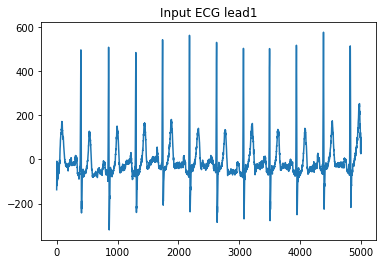

In [548]:
input,output = train_dataset[0]
input=input.tolist()
data=input[0]
data
plt.plot(data)
plt.title("Input ECG lead1")

Text(0.5, 1.0, 'Output ECG trained for 20epochs on 50 datapoints')

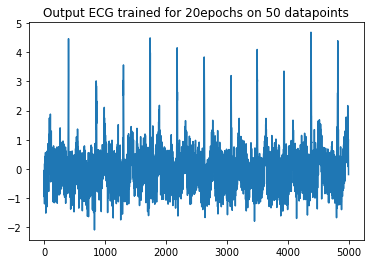

In [545]:
X,y=test_dataset[0]
model.eval()
with torch.inference_mode():
  output=model(X)
output=output.tolist()
data=output[0]
plt.plot(data)
plt.title("Output ECG trained for 20epochs on 50 datapoints")